In [1]:
from __future__ import print_function

from vis.input_modifiers import Jitter
from vis.callbacks import GifGenerator, Print
from vis.visualization import visualize_activation
from vis.utils import utils

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# 1. pretrain a small arch on mnist

In [41]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 50
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax', name='preds'))

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [42]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [43]:
[(l.name, l.output_shape) for l in model.layers]

[('conv2d_33', (None, 28, 28, 32)),
 ('max_pooling2d_28', (None, 14, 14, 32)),
 ('dropout_29', (None, 14, 14, 32)),
 ('conv2d_34', (None, 14, 14, 64)),
 ('max_pooling2d_29', (None, 7, 7, 64)),
 ('dropout_30', (None, 7, 7, 64)),
 ('conv2d_35', (None, 7, 7, 32)),
 ('max_pooling2d_30', (None, 3, 3, 32)),
 ('dropout_31', (None, 3, 3, 32)),
 ('conv2d_36', (None, 3, 3, 32)),
 ('max_pooling2d_31', (None, 1, 1, 32)),
 ('dropout_32', (None, 1, 1, 32)),
 ('flatten_7', (None, 32)),
 ('preds', (None, 10))]

In [44]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 304us/step - loss: 1.0690 - acc: 0.6312 - val_loss: 0.1812 - val_acc: 0.9507
Epoch 2/10
60000/60000 [==============================] - 16s 271us/step - loss: 0.4905 - acc: 0.8484 - val_loss: 0.1081 - val_acc: 0.9712
Epoch 3/10
60000/60000 [==============================] - 16s 268us/step - loss: 0.3912 - acc: 0.8820 - val_loss: 0.0772 - val_acc: 0.9780
Epoch 4/10
60000/60000 [==============================] - 16s 268us/step - loss: 0.3536 - acc: 0.8937 - val_loss: 0.0691 - val_acc: 0.9798
Epoch 5/10
60000/60000 [==============================] - 16s 272us/step - loss: 0.3234 - acc: 0.9032 - val_loss: 0.0580 - val_acc: 0.9828
Epoch 6/10
60000/60000 [==============================] - 16s 268us/step - loss: 0.3024 - acc: 0.9110 - val_loss: 0.0577 - val_acc: 0.9833
Epoch 7/10
60000/60000 [==============================] - 16s 266us/step - loss: 0.2919 - acc: 0.9143 - val_loss: 0.

# 2. Re-train final layers

<IPython.core.display.Javascript object>


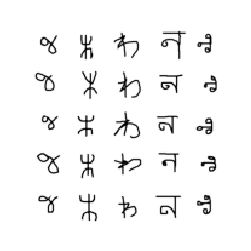

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
def gen_omniglot(N = 2, n_samples_print=5):
    features = np.load('./Data/omniglot_inceptionV3_features.npy')
    n_classes, n_samples, n_features = features.shape
    classes = np.random.choice(np.arange(features.shape[0]), size=N, replace=False)
    images = np.load('./Data/omniglot.npy')
    n_classes, n_samples, n_pixels = images.shape
    imgs = np.reshape(images[classes, :, :], (N,n_samples, 28, 28))
    plt.figure(figsize=(N//2, 2))
    for i in range (N):
        for j in range(n_samples_print):
            plt.subplot2grid((n_samples_print, N), (j, i))
            img = imgs[i, j, ... ].squeeze()
            plt.imshow(img, cmap='Greys_r')
            plt.axis('off')
    X = np.reshape(images[classes, :, :], (N*n_samples, 28, 28, 1))
    y = np.repeat(np.arange(N), n_samples).reshape(N*n_samples, 1)
    return X, y
# sample a subset of omniglot
N=5
np.random.seed(0)
X, y = gen_omniglot(N=N)
X.shape, y.shape
# separate validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.20, stratify=y)

In [37]:
preds = Dense(N, activation='softmax', use_bias=False)(model.layers[-2].output)
new_model = Model(model.input, preds)

In [46]:
# freeze first layers
for layer in new_model.layers[0:-1]:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optmizer = keras.optimizers.Adam(lr=0.0001)
new_model.compile(optimizer=optmizer, loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model on the new data for a few epochs
new_model.fit(X_train, keras.utils.to_categorical(y_train, N), 
          batch_size=50, epochs=50, verbose=2, shuffle=True,
          validation_data=(X_val, keras.utils.to_categorical(y_val, N)))

Train on 20 samples, validate on 80 samples
Epoch 1/50
 - 1s - loss: 1.8672 - acc: 0.1500 - val_loss: 1.6522 - val_acc: 0.1375
Epoch 2/50
 - 0s - loss: 1.9383 - acc: 0.2000 - val_loss: 1.6521 - val_acc: 0.1375
Epoch 3/50
 - 0s - loss: 1.6903 - acc: 0.3000 - val_loss: 1.6521 - val_acc: 0.1375
Epoch 4/50
 - 0s - loss: 1.6503 - acc: 0.3000 - val_loss: 1.6521 - val_acc: 0.1375
Epoch 5/50
 - 0s - loss: 1.9710 - acc: 0.2000 - val_loss: 1.6520 - val_acc: 0.1375
Epoch 6/50
 - 0s - loss: 1.8179 - acc: 0.1500 - val_loss: 1.6520 - val_acc: 0.1375
Epoch 7/50
 - 0s - loss: 1.8762 - acc: 0.2000 - val_loss: 1.6519 - val_acc: 0.1375
Epoch 8/50
 - 0s - loss: 1.8078 - acc: 0.3500 - val_loss: 1.6519 - val_acc: 0.1375
Epoch 9/50
 - 0s - loss: 2.4066 - acc: 0.1500 - val_loss: 1.6518 - val_acc: 0.1375
Epoch 10/50
 - 0s - loss: 1.9213 - acc: 0.1000 - val_loss: 1.6518 - val_acc: 0.1375
Epoch 11/50
 - 0s - loss: 1.8052 - acc: 0.1000 - val_loss: 1.6518 - val_acc: 0.1375
Epoch 12/50
 - 0s - loss: 2.2508 - acc: 0

In [40]:
layer_idx = -1
new_model.layers[layer_idx].activation = keras.activations.linear
new_model = utils.apply_modifications(new_model)

In [41]:
from tqdm import tqdm
vis_images = []
for idx in tqdm(range(N)):
    img = visualize_activation(
        new_model, layer_idx,  idx,
        act_max_weight=10, lp_norm_weight=10, tv_weight=10, 
        max_iter=300, verbose=False, 
        input_modifiers=[Jitter()])
    vis_images.append(img)

100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


<IPython.core.display.Javascript object>


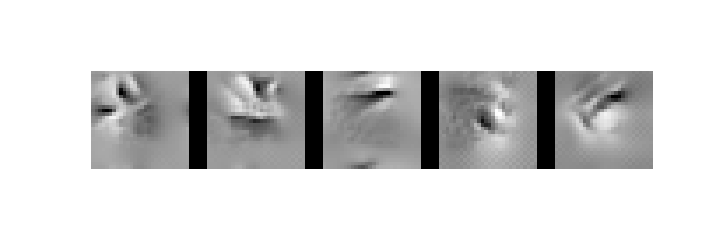

(-0.5, 159.5, 27.5, -0.5)

In [42]:
# Generate stitched image palette
stitched = utils.stitch_images(vis_images, cols=5)
plt.figure()
plt.imshow(stitched.squeeze(), cmap='Greys_r')
plt.axis('off')